In [97]:

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [98]:
data_dir = r"D:\classified_music\dataset"

In [99]:
img_height,img_width=225,225
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7371 files belonging to 7 classes.
Using 5897 files for training.


In [100]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7371 files belonging to 7 classes.
Using 1474 files for validation.


In [101]:
class_names = ['bolero','CachMang', 'danca','NhacTrinh', 'Rapviet','RockViet','TruTinh']

In [102]:
class_names = train_ds.class_names
print(class_names)

['CachMang', 'NhacTrinh', 'Rapviet', 'RockViet', 'TruTinh', 'bolero', 'danca']


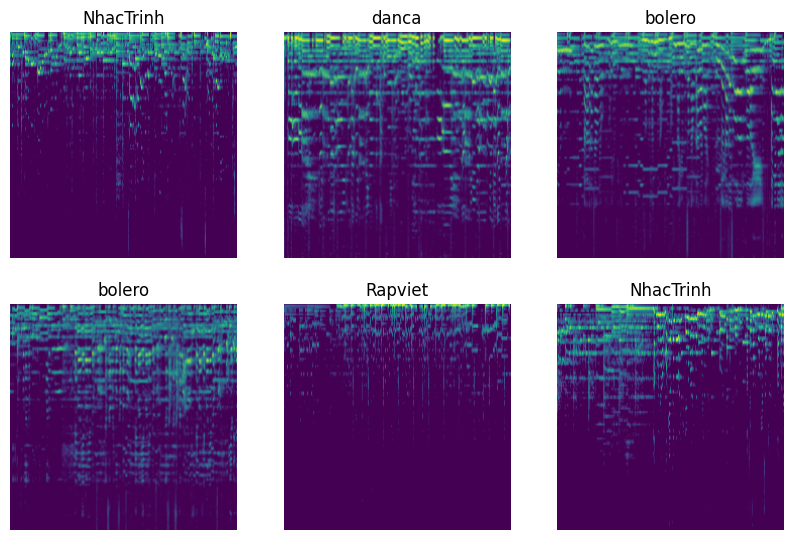

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [104]:
print("Các lớp trong train_ds:", train_ds.class_names)
print("Số lớp:", len(train_ds.class_names))


Các lớp trong train_ds: ['CachMang', 'NhacTrinh', 'Rapviet', 'RockViet', 'TruTinh', 'bolero', 'danca']
Số lớp: 7


In [105]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Load model ResNet50 (không có lớp top FC)
base_model = ResNet50(include_top=False,
                      input_shape=(225, 225, 3),
                      pooling='avg',
                      weights='imagenet')

# Đóng băng các lớp pretrained
# for layer in base_model.layers:
#     layer.trainable = False

# Functional API
inputs = layers.Input(shape=(225, 225, 3))
x = base_model(inputs, training=False)  # Pass input qua ResNet
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

resnet_model = models.Model(inputs, outputs)


In [106]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath=r'D:\classified_music\check_point_resnet\best_model_epoch_{epoch:02d}_acc_{val_accuracy:.2f}.keras',      # Tên file lưu model tốt nhất
    monitor='val_accuracy',        # Chọn tiêu chí để đánh giá "tốt nhất"
    save_best_only=True,           # Chỉ lưu khi tốt hơn trước
    mode='max',                    # Nếu dùng 'val_accuracy' => 'max'; nếu 'val_loss' => 'min'
    verbose=2
)

In [107]:
# for layer in base_model.layers[-20:]:
#     layer.trainable = True
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [108]:
resnet_model.summary()

epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]

)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 225, 225, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dense_13 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 24,640,391
Trainable params: 24,587,271
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/10
185/185 [==============================] - ETA: 0s - loss: 1.0900 - accuracy: 0.5716 
Epoch 1: val_accuracy improved from -inf to 0.69607, saving model to D:\class

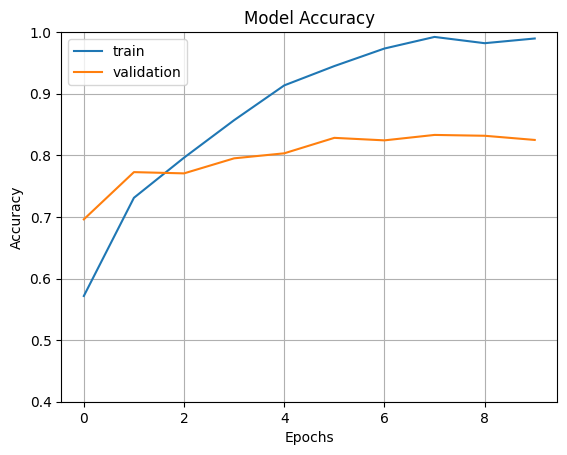

In [112]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [113]:
resnet_model.save(r'D:\classified_music\check_point_resnet\resnet_model_lastest.keras') 

In [114]:
from tensorflow.keras.models import load_model

model = load_model(r'D:\classified_music\check_point_resnet\resnet_model_best.keras')

In [174]:
from PIL import Image
file_path = r"D:\classified_music\dataset\TruTinh\02-MuaYeu._segment_1.png"
image = Image.open(file_path).convert("RGB")
image = image.resize((img_width, img_height))
image = np.expand_dims(np.array(image), axis=0)
print(image.shape)
predictions = model.predict(image)

(1, 225, 225, 3)
1/1 [==============================] - 1s 877ms/step


In [175]:
predictions = model.predict(image)
confidences = predictions[0]
predicted_index = np.argmax(confidences)
confidence_score = confidences[predicted_index]

1/1 [==============================] - 1s 872ms/step


In [176]:
output_class=class_names[np.argmax(predictions)]
print(f"The predicted class is :{output_class} confident :{confidence_score:.2%}")

The predicted class is :Rapviet confident :90.57%
